# Mettre en place notre environnement
________

La première chose que nous devons faire est de charger les bibliothèques et les ensembles de données que nous allons utiliser. Pour aujourd'hui, nous allons travailler avec deux ensembles de données : un contenant des chroniques de température dans le lit de la rivière (zone hyporhéique), et un autre contenant des les chroniques de différence de charge enregistré en **Volt**.

**Important!** Assurez-vous d'exécuter cette cellule vous-même ou le reste de votre code ne fonctionnera pas

In [1]:
# modules
import collections as cl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

In [2]:
# read in our data
capteur_riviere = pd.read_csv("./MOLONARI_1D_RESOURCES/sampling_points/Point034/point034_P_measures.csv",header=1)
capteur_ZH = pd.read_csv("./MOLONARI_1D_RESOURCES/sampling_points/Point034/point034_T_measures.csv",header=1)
etalonnage_capteur_riv = pd.read_csv("./MOLONARI_1D_RESOURCES/configuration/pressure_sensors/P508.csv")

# set seed for reproducibility
np.random.seed(0)

In [3]:
capteur_riviere["Date Heure, GMT+01:00"] = pd.to_datetime(capteur_riviere["Date Heure, GMT+01:00"])

In [4]:
capteur_ZH["Date Heure, GMT+01:00"] = pd.to_datetime(capteur_ZH["Date Heure, GMT+01:00"])

Nous sommes maintenant prêts à examiner quelques dates ! (Si vous le souhaitez, vous pouvez profiter de cette occasion pour jeter un coup d'œil à certaines des données).

# Imprimez le noms des colonnes
renommer les colonnes du fichier capteur_riviere :  	dates,tension_V,temperature_stream_C et celles du fichier capteur_ZH  :
#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C



In [5]:
# list(capteur_riviere.columns)[-3:]: get the last 3 elements of capteur_riviere.columns

In [6]:
capteur_riviere.drop(labels = list(capteur_riviere.columns)[-3:],axis=1,inplace=True)
capteur_riviere.rename(columns={'#': '#', list(capteur_riviere.columns)[1]: 'dates',list(capteur_riviere.columns)[2]: 'tension_V',
                                list(capteur_riviere.columns)[3]:'temperature_stream_C'}, inplace =  True)


capteur_ZH.drop(labels = list(capteur_ZH.columns)[-3:],axis=1,inplace=True)
capteur_ZH.rename(columns={'#': '#', list(capteur_ZH.columns)[1]: 'dates', list(capteur_ZH.columns)[2]: 'temperature_depth_1_C',
                           list(capteur_ZH.columns)[3]:'temperature_depth_2_C', list(capteur_ZH.columns)[4]:'temperature_depth_3_C',
                           list(capteur_ZH.columns)[5]:'temperature_depth_4_C'}, inplace =  True)

# Transformez les données de différence de charge en mètres



In [7]:
# etalonnage_capteur_riv.iloc[2] : the third row(indexed 2) of etalonnage_capteur_riv
# list(etalonnage_capteur_riv.columns)[-1] : just the string 'P508'

In [8]:
intercept = float(etalonnage_capteur_riv.iloc[2][list(etalonnage_capteur_riv.columns)[-1]])
dUdH = float(etalonnage_capteur_riv.iloc[3][list(etalonnage_capteur_riv.columns)[-1]])
dUdT = float(etalonnage_capteur_riv.iloc[4][list(etalonnage_capteur_riv.columns)[-1]])
capteur_riviere["charge_m"] = (capteur_riviere["tension_V"]-capteur_riviere["temperature_stream_C"]*dUdT-intercept)/dUdH
capteur_riviere.head()
capteur_ZH.tail()
# charge_m = (tens_V-temp_C·dU/dT-Intercept)/(dU/dH)
# df["a*b"] = df["a"] * df["b"]

,#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C
1433,1434,2016-07-12 10:15:00,14.457,14.697,14.792,14.649
1434,1435,2016-07-12 10:30:00,15.008,14.792,14.816,14.649
1435,1436,2016-07-12 10:45:00,17.320,17.296,17.034,17.130
1436,1437,2016-07-12 10:49:31,NaN,NaN,NaN,NaN
1437,1438,2016-07-12 10:49:47,NaN,NaN,NaN,NaN


# Traitement des dates
## Vérifiez le type de données de notre colonne de date
___

Imprimer les dates des deux fichiers

In [9]:
capteur_riviere['dates']
capteur_ZH['dates']

0      2016-06-27 12:00:00
1      2016-06-27 12:15:00
2      2016-06-27 12:30:00
3      2016-06-27 12:45:00
4      2016-06-27 13:00:00
               ...        
1433   2016-07-12 10:15:00
1434   2016-07-12 10:30:00
1435   2016-07-12 10:45:00
1436   2016-07-12 10:49:31
1437   2016-07-12 10:49:47
Name: dates, Length: 1438, dtype: datetime64[ns]

Remarquez qu'en bas de la sortie de `head()`, vous pouvez voir qu'il est dit que le type de données de cette colonne est "object". 

> Pandas utilise le dtype "object" pour stocker différents types de données, mais le plus souvent, lorsque vous voyez une colonne avec le dtype "object", elle contient des chaînes de caractères. 

Si vous consultez la documentation sur le dtype de Pandas [ici] (http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes), vous remarquerez qu'il existe également un dtype spécifique `datetime64`. Comme le dtype de notre colonne est `object` plutôt que `datetime64`, nous pouvons dire que Python ne sait pas que cette colonne contient des dates.

Nous pouvons aussi regarder uniquement le dtype de votre colonne sans imprimer les premières lignes si nous le souhaitons :

In [10]:
# check the data type of our date column
print(type(capteur_riviere['dates'].dtypes))

<class 'numpy.dtype[datetime64]'>


In [11]:
print(type(capteur_ZH['dates'].dtypes))

<class 'numpy.dtype[datetime64]'>


You may have to check the [numpy documentation](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) to match the letter code to the dtype of the object. "O" is the code for "object", so we can see that these two methods give us the same information.

## Convertir nos colonnes de date en datetime
___

Maintenant que nous savons que notre colonne de date n'est pas reconnue comme une date, il est temps de la convertir pour qu'elle soit reconnue comme une date. Cette opération est appelée "analyse syntaxique des dates" car nous prenons une chaîne de caractères et identifions ses composants. Nous allons utiliser la fonction pd.to_datetime.

Nous pouvons indiquer à pandas le format de nos dates à l'aide d'un guide appelé ["strftime directive", sur lequel vous trouverez plus d'informations à ce lien] (http://strftime.org/). L'idée de base est que vous devez indiquer quelles parties de la date se trouvent où et quelle ponctuation se trouve entre elles. Il existe [de nombreuses parties possibles d'une date](http://strftime.org/), mais les plus courantes sont `%d` pour le jour, `%m` pour le mois, `%y` pour une année à deux chiffres et `%Y` pour une année à quatre chiffres.

Quelques exemples :

 * Le 17 janvier 2007 a le format "%m/%d/%y".
 * 17-1-2007 a le format "%d-%m-%Y".
 

In [12]:
capteur_riviere['dates'] = pd.to_datetime(capteur_riviere['dates'], infer_datetime_format=True)
capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'], infer_datetime_format=True)
print(type(capteur_riviere['dates'].dtypes))
print(type(capteur_ZH['dates'].dtypes))

<class 'numpy.dtype[datetime64]'>
<class 'numpy.dtype[datetime64]'>


Maintenant que nos dates sont analysées correctement, nous pouvons travailler avec celles-ci.

___
* Bien que nous spécifions le format de la date ici, il arrive parfois que vous rencontriez une erreur lorsque plusieurs formats de date sont présents dans une même colonne. Dans ce cas, vous pouvez demander à pandas de déduire le bon format de date. Vous pouvez le faire comme suit :

`capteur_riviere['date'] = pd.to_datetime(capteur_riviere['date'], infer_datetime_format=True)``

**Pourquoi ne pas toujours utiliser `infer_datetime_format = True?`** Il y a deux grandes raisons de ne pas toujours faire deviner à pandas le format de l'heure. La première est que pandas n'est toujours capable de trouver le bon format de date, surtout si quelqu'un a fait preuve de créativité dans la saisie des données. La seconde est que c'est beaucoup plus lent que de spécifier le format exact des dates.
____

## Tracer le jour du mois pour vérifier l'analyse de la date
___

L'un des plus grands dangers de l'analyse des dates est de mélanger les mois et les jours. La fonction to_datetime() a des messages d'erreur très utiles, mais il n'est pas inutile de vérifier que les jours du mois que nous avons extraits ont un sens. 

Pour ce faire, nous allons tracer un histogramme des jours du mois. Nous nous attendons à ce qu'il ait des valeurs entre 1 et 31 et, puisqu'il n'y a aucune raison de supposer que les glissements de terrain sont plus fréquents certains jours du mois que d'autres, une distribution relativement égale. (Avec un creux sur 31 car tous les mois n'ont pas 31 jours.) 

In [13]:
capteur_riviere

,#,dates,tension_V,temperature_stream_C,charge_m
0,1.0,2016-06-27 12:00:00,1.26787,18.342,-0.020848
1,2.0,2016-06-27 12:15:00,1.06630,13.898,0.112499
2,3.0,2016-06-27 12:30:00,1.20661,13.915,0.016578
3,4.0,2016-06-27 12:45:00,1.24533,13.939,-0.009873
4,5.0,2016-06-27 13:00:00,1.24437,13.967,-0.009189
...,...,...,...,...,...
1455,1447.0,2016-07-12 15:45:00,1.13668,9.126,0.059567
1456,1447.7,2016-07-12 16:00:00,1.33513,9.157,-0.076095
1457,1448.4,2016-07-12 16:15:00,1.38926,9.199,-0.113065
1458,1449.1,2016-07-12 16:30:00,1.41386,9.244,-0.129840


In [14]:
capteur_ZH

,#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C
0,1,2016-06-27 12:00:00,13.810,13.834,13.858,13.810
1,2,2016-06-27 12:15:00,13.834,13.858,13.882,13.834
2,3,2016-06-27 12:30:00,13.930,13.954,14.050,14.002
3,4,2016-06-27 12:45:00,13.882,13.954,14.026,13.954
4,5,2016-06-27 13:00:00,13.858,13.930,14.026,13.954
...,...,...,...,...,...,...
1433,1434,2016-07-12 10:15:00,14.457,14.697,14.792,14.649
1434,1435,2016-07-12 10:30:00,15.008,14.792,14.816,14.649
1435,1436,2016-07-12 10:45:00,17.320,17.296,17.034,17.130
1436,1437,2016-07-12 10:49:31,NaN,NaN,NaN,NaN


(array([96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 68.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        48., 96., 96., 96.,  0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32.]),
 <BarContainer object of 31 artists>)

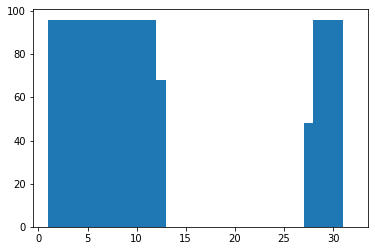

In [15]:
days = capteur_riviere["dates"].dt.day
plt.hist(days,range=[1,32],bins=31)

In [16]:
df = pd.DataFrame(days)
df.value_counts()

dates
1        96
2        96
3        96
4        96
5        96
6        96
7        96
8        96
9        96
10       96
11       96
28       96
29       96
30       96
12       68
27       48
dtype: int64

# Valeurs aberrantes(离群值/outlier)

<b>L'un des plus grands défis du nettoyage des données est l'identification et le traitement des valeurs aberrantes.</b> En termes simples, les valeurs aberrantes sont des observations qui sont significativement différentes des autres points de données. Même les meilleurs algorithmes d'estimation des paramètres automatique seront moins performants si les observations aberrantes ne sont pas nettoyées des données, car elles impliquent des simulations obsolètes des variables.



## Identification des valeurs aberrantes

La présence de valeurs aberrantes dans les données peut avoir de nombreuses raisons. Parfois, les valeurs aberrantes peuvent être authentiques, alors que dans d'autres cas, elles peuvent être dues à des erreurs de saisie de données. Il est important de comprendre les raisons des valeurs aberrantes avant de les nettoyer.

Nous allons commencer le processus de recherche des valeurs aberrantes en exécutant les statistiques sommaires sur les variables. Pour ce faire, nous utilisons la fonction describe() ci-dessous, qui fournit un résumé statistique de toutes les variables quantitatives.




In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   dates   1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [18]:
capteur_riviere[["charge_m","temperature_stream_C"]].describe()

,charge_m,temperature_stream_C
count,1460.000000,1460.000000
mean,-0.016812,14.896441
std,0.032176,1.142397
min,-0.140099,9.066000
25%,-0.025327,14.203750
50%,-0.020557,14.818000
75%,-0.009784,15.555000
max,0.390494,18.342000


In [19]:
capteur_ZH[["temperature_depth_1_C","temperature_depth_2_C","temperature_depth_3_C","temperature_depth_4_C"]].describe()

,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C
count,1436.000000,1436.000000,1436.000000,1436.000000
mean,14.717557,14.502795,14.348946,14.097808
std,0.721799,0.531472,0.423288,0.328507
min,13.329000,13.642000,13.762000,13.690000
25%,14.146000,14.098000,14.050000,13.882000
50%,14.625000,14.409000,14.242000,14.002000
75%,15.127000,14.768000,14.505000,14.194000
max,17.320000,17.296000,17.034000,17.130000


## Tracez les graphiques de distribution pour les différentes variables

#### 1. Box plot

Le box plot est une manière standardisée d'afficher la distribution des données sur la base du résumé en cinq chiffres (minimum, premier quartile (Q1), médiane, troisième quartile (Q3) et maximum). Elle est souvent utilisée pour identifier la distribution des données et détecter les valeurs aberrantes. La ligne de code ci-dessous trace le box plot de la variable numérique. 

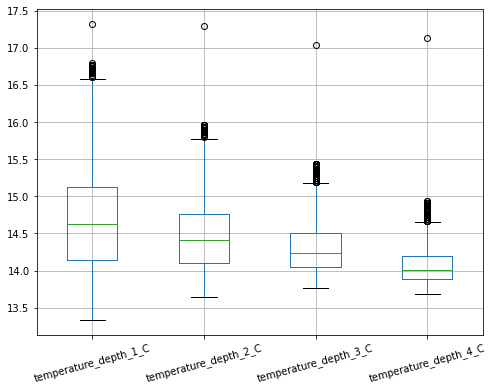

In [20]:
capteur_ZH.boxplot(figsize=(8,6),column = ["temperature_depth_1_C","temperature_depth_2_C","temperature_depth_3_C","temperature_depth_4_C"])
plt.xticks(rotation=15)
plt.show()

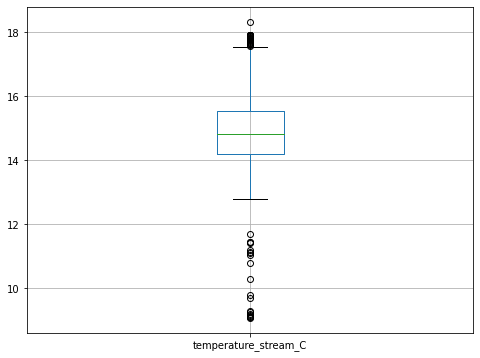

In [21]:
capteur_riviere[["temperature_stream_C"]].boxplot(figsize=(8,6))
plt.show()

## 2. Histogramme

Un histogramme est utilisé pour visualiser la distribution d'une variable numérique. Une valeur aberrante apparaît en dehors du modèle général de distribution. La ligne de code ci-dessous trace un histogramme de la variable, en utilisant la fonction hist().

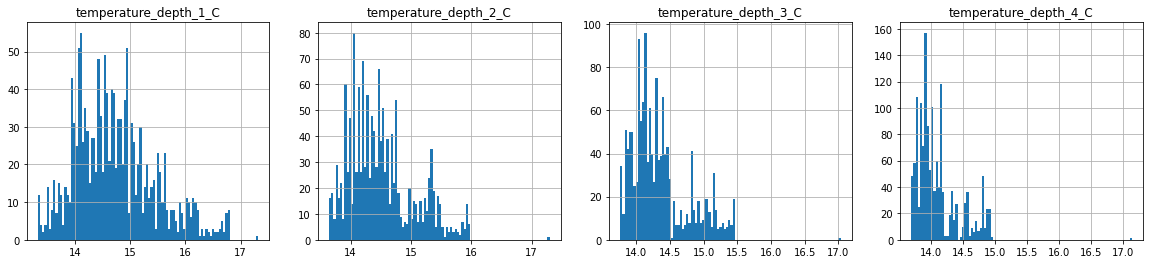

In [22]:
capteur_ZH[["temperature_depth_1_C","temperature_depth_2_C","temperature_depth_3_C","temperature_depth_4_C"]].hist(bins=100,figsize=(20,4),layout=(1,4))
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.show()

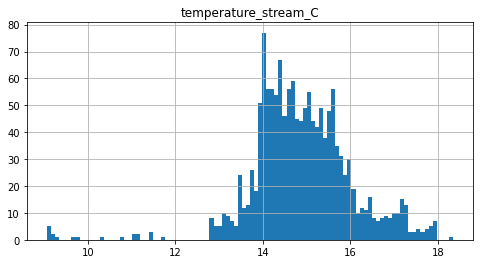

In [23]:
capteur_riviere[["temperature_stream_C"]].hist(bins=100,figsize=(8,4))
plt.show()

## 3. Scatterplot

Un nuage de points permet de visualiser la relation entre deux variables quantitatives. Les données sont affichées sous la forme d'une collection de points, et tout point qui ne correspond pas au regroupement général des deux variables peut indiquer des valeurs aberrantes. 

génèrez un nuage de points entre les différentes variables de températures. 



In [24]:
df = capteur_ZH[["dates","temperature_depth_1_C","temperature_depth_2_C","temperature_depth_3_C","temperature_depth_4_C"]].copy()

In [25]:
df["temperature_stream_C"] = capteur_riviere[["temperature_stream_C"]]

In [26]:
df["temperature_stream_C"].tail()

1433    14.285
1434    14.306
1435    14.306
1436    14.306
1437    14.306
Name: temperature_stream_C, dtype: float64

In [27]:
capteur_riviere.count()

#                       1460
dates                   1460
tension_V               1460
temperature_stream_C    1460
charge_m                1460
dtype: int64

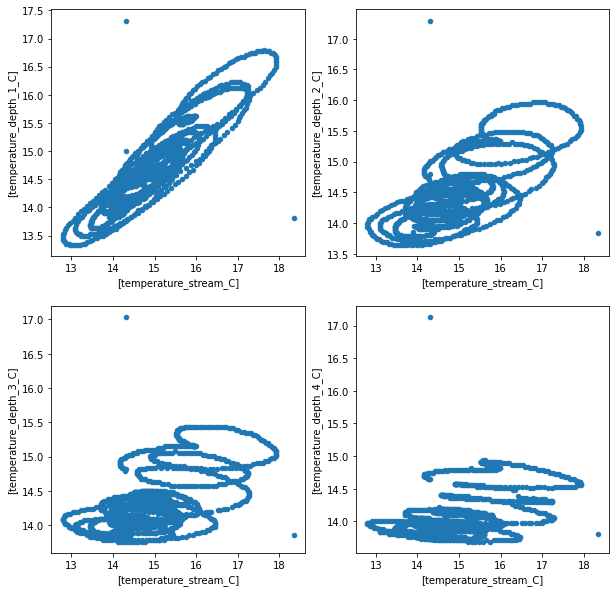

In [28]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
ax1 = df.plot.scatter(x = ['temperature_stream_C'], y = ['temperature_depth_1_C'],ax=axs[0,0])
ax2 = df.plot.scatter(x = ['temperature_stream_C'], y = ['temperature_depth_2_C'],ax=axs[0,1])
ax3 = df.plot.scatter(x = ['temperature_stream_C'], y = ['temperature_depth_3_C'],ax=axs[1,0])
ax4 = df.plot.scatter(x = ['temperature_stream_C'], y = ['temperature_depth_4_C'],ax=axs[1,1])
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.show()


<Figure size 432x288 with 0 Axes>

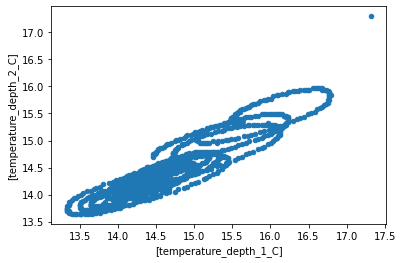

In [29]:
plt.figure(0)
df.plot.scatter(x = ['temperature_depth_1_C'], y = ['temperature_depth_2_C'])
plt.show()

# Identification des valeurs aberrantes avec l'écart interquartile (IQR)

L'écart interquartile (IQR) est une mesure de la dispersion statistique et est calculé comme la différence entre les 75e et 25e percentiles. Il est représenté par la formule IQR = Q3 - Q1. Les  lignes de code ci-dessous calculent et impriment l'écart interquartile pour chacune des variables de l'ensemble de données.  La règle générale est que tout ce qui n'est pas dans la plage de (Q1 - 1,5 IQR) et (Q3 + 1,5 IQR) est une valeur aberrante et peut être supprimé.


### Fonctions d'assistance

Ecrire des fonctions afin d'examiner chaque colonne des deux fichiers de données de terain et de calculer les 1er et 3e quartiles, l'intervalle inter-quartile et le minimum et le maximum. Toute valeur en dehors du minimum et du maximum est une valeur aberrante.

In [30]:
df.describe()

,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C,temperature_stream_C
count,1436.000000,1436.000000,1436.000000,1436.000000,1438.000000
mean,14.717557,14.502795,14.348946,14.097808,14.962416
std,0.721799,0.531472,0.423288,0.328507,1.000577
min,13.329000,13.642000,13.762000,13.690000,12.800000
25%,14.146000,14.098000,14.050000,13.882000,14.223500
50%,14.625000,14.409000,14.242000,14.002000,14.843000
75%,15.127000,14.768000,14.505000,14.194000,15.561000
max,17.320000,17.296000,17.034000,17.130000,18.342000


In [31]:
df_q25 = df.quantile(0.25)
df_q75 = df.quantile(0.75)
df_q25

temperature_depth_1_C    14.1460
temperature_depth_2_C    14.0980
temperature_depth_3_C    14.0500
temperature_depth_4_C    13.8820
temperature_stream_C     14.2235
Name: 0.25, dtype: float64

### Résolution de la distribution asymétrique…

A partir de nos données dans un histogramme, nous pouvons obtenir une distribution asymétrique des données. Une seule grande barre avec de minuscules barres à gauche ou à droite (ou les deux) est un signe révélateur que des valeurs aberrantes peuvent être présentes dans les données et cela signifie que notre bel histogramme, bien rangé et normalement distribué, est complètement caché et obscurci par le seul grand bar.


Lorsque nous observons ce modèle, nous devons supprimer les valeurs aberrantes, puis voir à quoi ressemble la nouvelle distribution. Si nous voulons vérifier la présence de valeurs aberrantes, une boîte à moustaches rapide confirmera ou refusera…

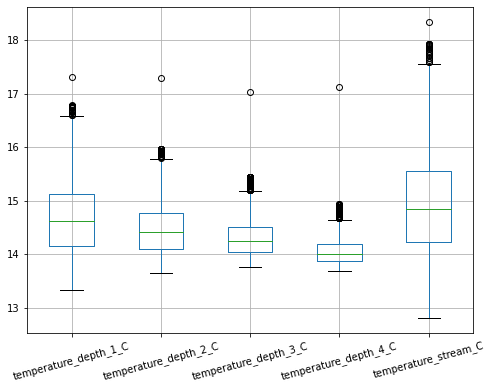

In [32]:
df.boxplot(figsize=(8,6))
plt.xticks(rotation=15)
plt.show()

## Suppression des valeurs aberrantes et visualisation du résultat

Après avoir fait tout le gros du travail dans les fonctions d'assistance, nous pouvons maintenant supprimer les lignes des données qui contiennent des valeurs aberrantes en dehors de | - et - | moustaches…

In [33]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

Store the original data

In [34]:
df_or = df.copy()

Remove "boxplot outliers"

In [35]:
for i in range(1,5):
    df = remove_outlier(df,"temperature_depth_"+str(i)+"_C")
df = remove_outlier(df,"temperature_stream_C")

<b>It looks a little strange(why there are still outliers?), but it's simply because when you move the outliers, the quantile number changes, and now we have new max and min, so it's possible that the "outliers" still exist.\
Here we think one round removal is enough. Although there are still some outliers gathered near Q3+1.5IQR, they are much less extreme.</b>

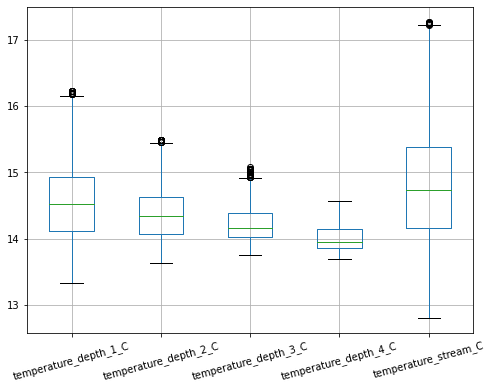

In [36]:
df.boxplot(figsize=(8,6))
plt.xticks(rotation=15)
plt.show()

In [38]:
df.isna().sum()

dates                    0
temperature_depth_1_C    0
temperature_depth_2_C    0
temperature_depth_3_C    0
temperature_depth_4_C    0
temperature_stream_C     0
dtype: int64

In [39]:
df.describe()

,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C,temperature_stream_C
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,14.581409,14.376368,14.236752,14.005132,14.831846
std,0.612682,0.409970,0.299157,0.208145,0.908559
min,13.329000,13.642000,13.762000,13.690000,12.800000
25%,14.116000,14.074000,14.026000,13.858000,14.158250
50%,14.529000,14.337000,14.170000,13.954000,14.732500
75%,14.936000,14.625000,14.385000,14.146000,15.384000
max,16.225000,15.485000,15.079000,14.577000,17.268000


In [45]:
df.tail(400)

,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C,temperature_stream_C
865,2016-07-06 12:15:00,13.425,13.642,13.834,13.810,13.500
866,2016-07-06 12:30:00,13.449,13.642,13.834,13.810,13.568
867,2016-07-06 12:45:00,13.449,13.642,13.810,13.810,13.620
868,2016-07-06 13:00:00,13.497,13.642,13.810,13.810,13.688
869,2016-07-06 13:15:00,13.497,13.642,13.786,13.786,13.751
...,...,...,...,...,...,...
1262,2016-07-10 15:30:00,15.700,15.079,14.840,14.529,16.872
1263,2016-07-10 15:45:00,15.748,15.103,14.840,14.529,16.957
1264,2016-07-10 16:00:00,15.796,15.127,14.864,14.529,17.049
1265,2016-07-10 16:15:00,15.867,15.151,14.864,14.505,17.140


<b>Here we want to find which data have been removed:</b>

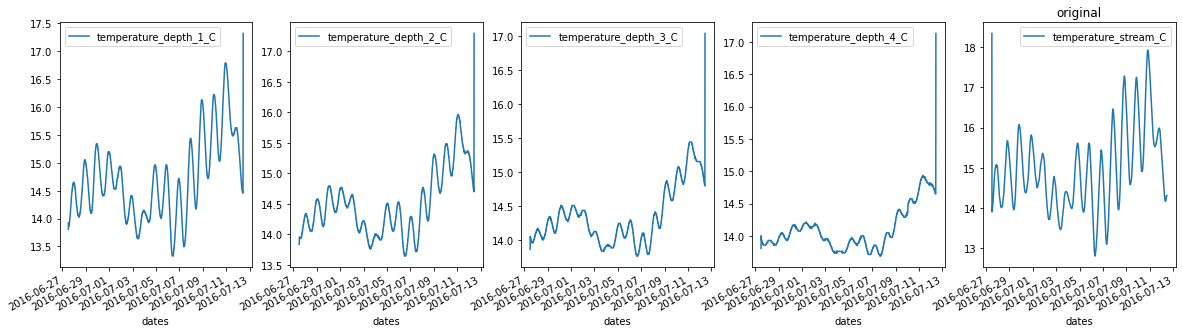

In [46]:
# original 
fig, axs = plt.subplots(1, 5,figsize=(20,5))
plt.title("original")
df_or.plot(x='dates',y='temperature_depth_1_C',ax = axs[0])
df_or.plot(x='dates',y='temperature_depth_2_C',ax = axs[1])
df_or.plot(x='dates',y='temperature_depth_3_C',ax = axs[2])
df_or.plot(x='dates',y='temperature_depth_4_C',ax = axs[3])
df_or.plot(x='dates',y='temperature_stream_C',ax = axs[4])
plt.show()

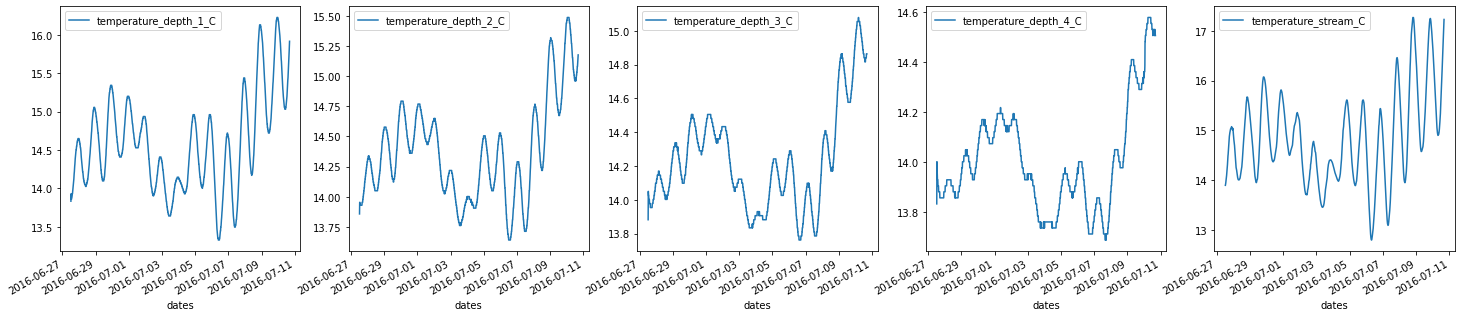

In [47]:
# without boxplot outliers
# original 
fig, axs = plt.subplots(1, 5,figsize=(25,5))
df.plot(x='dates',y='temperature_depth_1_C',ax = axs[0])
df.plot(x='dates',y='temperature_depth_2_C',ax = axs[1])
df.plot(x='dates',y='temperature_depth_3_C',ax = axs[2])
df.plot(x='dates',y='temperature_depth_4_C',ax = axs[3])
df.plot(x='dates',y='temperature_stream_C',ax = axs[4])
plt.show()

<b>Plot the common data in blue, outliers in red:</b>

In [48]:
df1 = df_or.copy()
df1.dropna(inplace = True)
result = pd.concat([df_or, df], axis=1)
df1['outliers'] = result[['temperature_depth_1_C']].iloc[:,1]
df1['outliers'][np.isnan(df1['outliers'])] = True
df1['outliers'][df1['outliers'] != True] = False

/tmp/ipykernel_1006/356220986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['outliers'][np.isnan(df1['outliers'])] = True


In [50]:
df1.head()

,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C,temperature_stream_C,outliers
0,2016-06-27 12:00:00,13.810,13.834,13.858,13.810,18.342,True
1,2016-06-27 12:15:00,13.834,13.858,13.882,13.834,13.898,False
2,2016-06-27 12:30:00,13.930,13.954,14.050,14.002,13.915,False
3,2016-06-27 12:45:00,13.882,13.954,14.026,13.954,13.939,False
4,2016-06-27 13:00:00,13.858,13.930,14.026,13.954,13.967,False


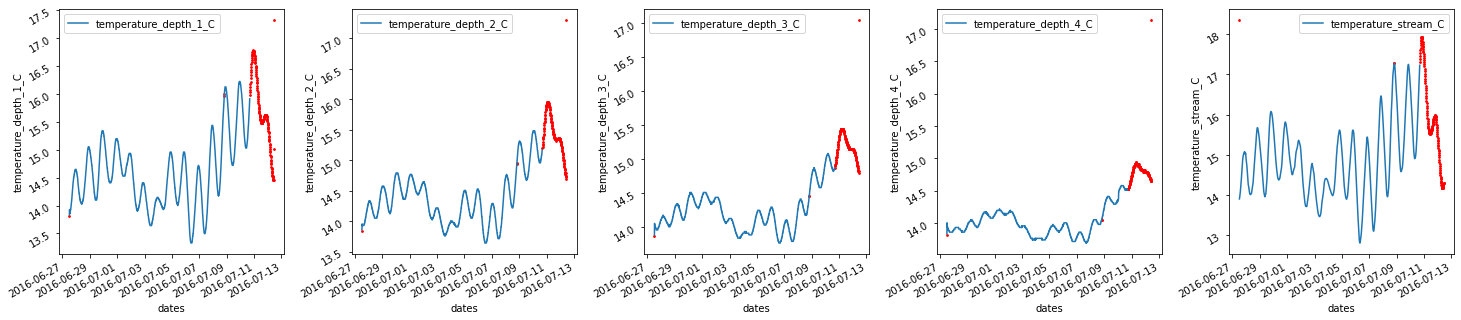

In [51]:
fig, axs = plt.subplots(1, 5,figsize=(25,5))
for i in range(4):
    df1[df1['outliers'] == False].plot(x='dates',y='temperature_depth_'+str(i+1)+'_C',ax = axs[i])
    df1[df1['outliers'] == True].plot.scatter(x='dates',y='temperature_depth_'+str(i+1)+'_C',c = 'r',s = 3,ax = axs[i])
    axs[i].tick_params(labelrotation=30)
df1[df1['outliers'] == False].plot(x='dates',y='temperature_stream_C',ax = axs[4])
df1[df1['outliers'] == True].plot.scatter(x='dates',y='temperature_stream_C',c = 'r',s = 3, ax = axs[4])
axs[4].tick_params(labelrotation=30)

plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.show()

## Expliquez le résultat
Est-ce que cette méthodologie vous semble suffisante? Tentez de trouver les limites de cette méthodologie?
Que pouvez vous apportez aux fonctions afin de les améliorer?

<b>This method successfully removed the outliers (removing the strange point shown in correlated scatter plot; significantly reducing the number of outliers in boxplot, although there are still some gathered near Q3+1.5IQR), but it may have overdone it. In fact, the temperature data we have here are time-series, and time-series have the trend to increase or decrease, which means that the criteria for "outliers" could vary across times, and some red outliers from July 10 to July 12 may be normal.</b>


<b>If a data is an outlier under different criterials, then we feel confident to say it is an outlier. \
    We are sure that the extreme points at the start(June 27) and the end(July 12-13) are outliers, because they are outliers observed from both scatter plot and box plot.</b>

## Valeurs abérantes avec la méthode score Z 
Il s'agit d'une unité mesurée en écart-type. Fondamentalement, il s'agit d'une mesure de la distance entre le score brut et la moyenne. Il est compris entre -3 et +3, où 0 = moyenne et 1 = écart-type, c'est-à-dire une distribution normale.

Cette méthode suggère qu'en tout point de données il existe une relation entre l'écart-type et la moyenne. Le score Z permet de trouver la distribution des données où la moyenne est égale à 0 et l'écart-type à 1, c'est-à-dire une distribution normale. Vous devez vous demander en quoi cela peut nous aider à identifier les valeurs aberrantes ? En calculant le score Z, nous redimensionnons et centrons les données et recherchons les points de données qui sont trop éloignés de zéro. Ces points de données qui sont trop éloignés de zéro seront traités comme des valeurs aberrantes. Dans la plupart des cas, un seuil de 3 ou -3 est utilisé, c'est-à-dire que si la valeur du score Z est supérieure ou inférieure à 3 ou -3 respectivement, ce point de données sera identifié comme aberrant.

Formule pour le score Z = (Observation - Moyenne)/Écart-type

z = (X - μ) / σ

Ecrire des functions afin de pouvoir appliquer cette méthodologie aux données

In [52]:
df2 = df_or.copy()
df2.dropna(inplace = True)
df2 = df2[(np.abs(stats.zscore(df2.iloc[:,1:])) < 3).all(axis=1)]

In [54]:
df2.describe()

,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C,temperature_stream_C
count,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000
mean,14.716375,14.501313,14.347416,14.095895,14.961432
std,0.718623,0.526400,0.417399,0.318732,0.997535
min,13.329000,13.642000,13.762000,13.690000,12.800000
25%,14.146000,14.098000,14.050000,13.882000,14.222250
50%,14.625000,14.409000,14.242000,14.002000,14.847500
75%,15.127000,14.768000,14.505000,14.194000,15.561000
max,16.796000,15.963000,15.438000,14.936000,17.928000


In [41]:
df3 = df_or.copy()
df3.dropna(inplace = True)
result = pd.concat([df_or, df2], axis=1)
df3['outliers'] = result[['temperature_depth_1_C']].iloc[:,1]
df3['outliers'][np.isnan(df3['outliers'])] = True
df3['outliers'][df3['outliers'] != True] = False

/tmp/ipykernel_468/2908408512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['outliers'][np.isnan(df3['outliers'])] = True


In [42]:
cl.Counter(df3['outliers'])

Counter({True: 2, False: 1434})

<b>We have only two outliers under Z-score method: starting point and ending point, showed in red</b>
<p><b>It is reasonable that the value is abnormal during the installation(start) and removal(end) of the detector</b>

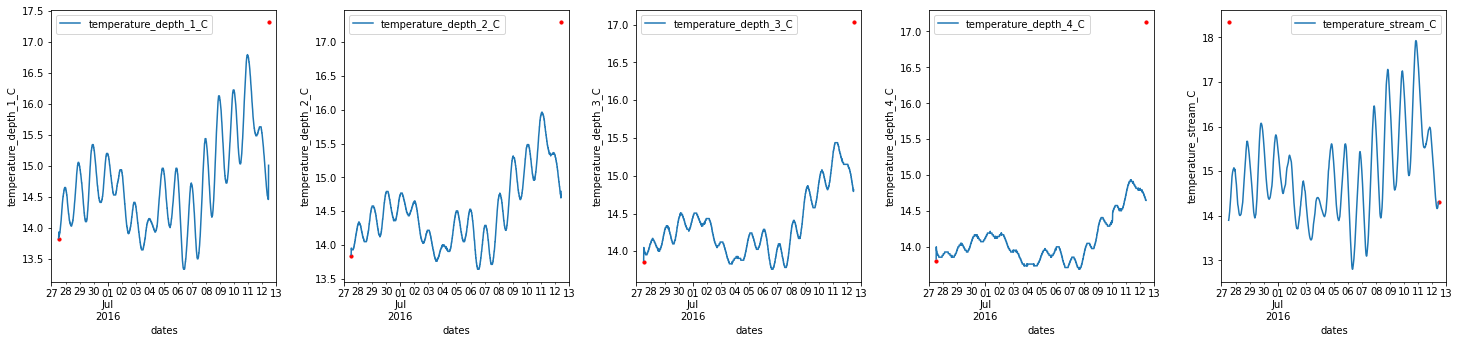

In [43]:
fig, axs = plt.subplots(1, 5,figsize=(25,5))
for i in range(4):
    df3[df3['outliers'] == False].plot(x='dates',y='temperature_depth_'+str(i+1)+'_C',ax = axs[i])
    df3[df3['outliers'] == True].plot.scatter(x='dates',y='temperature_depth_'+str(i+1)+'_C',c = 'r',s = 10,ax = axs[i])
    axs[i].set_xlim([datetime.date(2016, 6, 27), datetime.date(2016, 7, 13)])

df3[df3['outliers'] == False].plot(x='dates',y='temperature_stream_C',ax = axs[4])
df3[df3['outliers'] == True].plot.scatter(x='dates',y='temperature_stream_C',c = 'r',s = 10, ax = axs[4])
axs[4].set_xlim([datetime.date(2016, 6, 27), datetime.date(2016, 7, 13)])

plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.show()

## Comparer les deux méthodologies, donner leurs avantages et leurs limitations
Vous pouvez proposer des alternatives.

<p><b>Boxplot method:</b> Removing all suspected "outliers", but may overdone and lose some normal data<p>
<p><b>Z-score method:</b> Remove outliers more carefully<p>
<p><b>Limitation:</b> Both methods are "static", but data are time-series and can vary over time(seasonality, higher temperature in summer,...). For boxplot, it moves a lot of data from July 10 to July 12, but this increasing of temperature could may be a true reflection of seasonal changes<p>
<p><b>Improvement: </b> <p>1: Considering a localized method, inferring outlier bounds with local data. We can also identify outliers using rate of change.
    <p>2: Using different criterials together, confirming outliers if it meets different criteria.<p>

## Proposer une fonction permettant d'aller des données brutes jusqu'au premier traitement des données.

N'oubliez pas de permettre à l'utilisateur de pouvoir prendre des décisions et de l'aider à prendre ces décisions
Pensez à indiquer à l'utilisateur si le jeu de données est utilisable, quels sont les capteurs défaillant, quel semble être l'orientation des échanges nappe-rivière, les données de différence de charge semblent t'elles données les mêmes informations que les données du profils de température.

Votre function doit prendre en entrée, les trois fichiers et proposer au fur et à mesure de son dérouler des propositions à l'utilisateur.

The next function is a Graphical User Interface which allows the user to go over the whole process of analysis of the raw data and review each information separately. 

Firstly, it allows to select the path of the files one by one. Checks if the extension is ".csv" and, when upploading, it handle some errors such as: corrupted file, file in a different format as expected, error getting the charge, etc.

The next option is to plot the histogram over the days to verify that the files have been uploaded properly.

Then, the user can decide which variable wants to plot. It could be either a histogram, box plot, or even a scatter plot comparing two variables to see their relationship. In all of these cases, it is explained how to identify the outliers just by looking at the graphs.

Furthermore, there are two sections to apply the two methods for removing outliers: method IQR and method Z. Each one has a short explanation of how it works and, once they're applied, it shows how many points were deleted (original data sets are still keeped so there is no loss of information. These new cleaned data sets can now be reviewed in the histogram, box or scatter plots mentionned before.

Finally, the user can plot any variable to see which points have been deleted with each method. Deleted points are red and the blue line is the resulting data. There, the user can also find a brief explanation about how to interpret the "charge_m" plot and it is shown if the information is enough to conclude if the sensors are coherent or not in infiltrating regime. If there is enough data, it would be coherent if both "temperature_stream_C" and "temperature_depth_1_C" increase or decrease at any instant i. Over all the data analysed, it is given a coherence percentage.

The user can upload different files at any moment without needing to restart the application



# Deux autres jeux de données sont disponibles sur le répertoire github.
Votre rôle est de traiter et d'analyser ces données avec la méthodologie que vous avez développé